In [79]:
import pyspark.sql.functions as F
import datetime as dt
import pandas as pd
import pyspark.sql.types as st
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("whitegrid")
sc.setLogLevel("INFO")
udf = F.udf
%matplotlib inline

In [56]:
PERIODS = {}
N_WEEKS = 6
for i in range(1, N_WEEKS + 1):
    PERIODS[i] = {
        'start': i * 7,
        'end': i * 7 + 6
    }


def date_plus_x_days(date, x):
    """
    Returns a string date x days away from <date>
    
    Params:
    date (str): date in %Y%m%s format
    x (int) number of days to add to <date> (can be negative)
    
    >>> date_plus_x_days("20180101", 1)
    "20180102"
    
    >>> date_plus_x_days("20180510", -9)
    "20180501"
    """
    new_date = dt.datetime.strptime(date, '%Y%m%d') + dt.timedelta(days=x)
    return new_date.strftime('%Y%m%d')


def date_diff(d1, d2, fmt='%Y%m%d'):
    """
    Returns days elapsed from d2 to d1 as an integer

    Params:
    d1 (str)
    d2 (str)
    fmt (str): format of d1 and d2 (must be the same)

    >>> date_diff('20170205', '20170201')
    4

    >>> date_diff('20170201', '20170205)
    -4
    """
    try:
        return (pd.to_datetime(d1, format=fmt) - 
                pd.to_datetime(d2, format=fmt)).days
    except:
        return None


@udf(returnType=st.IntegerType())
def get_period(anchor, submission_date_s3):
    """
    Given an anchor and a submission_date_s3,
    returns what period a ping belongs to. This 
    is a spark UDF (see decoration).

    Params:
    anchor (col): anchor date
    submission_date_s3 (col): a ping's submission_date to s3

    Global:
    PERIODS (dict): defined globally based on n-week method

    Returns an integer indicating the retention period
    """
    if anchor is not None:
        diff = date_diff(submission_date_s3, anchor)
        if diff >= 7: # exclude first 7 days
            for period in sorted(PERIODS):
                if diff <= PERIODS[period]['end']:
                    return period

### Data Prep

Load in cleaned experiment data, generated from [this notebook](https://github.com/mozilla/taar/blob/master/analysis/TAARExperimentV2Analysis.ipynb).

In [10]:
S3_PATH = "s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/cleaned_data/"
clean_data = sqlContext.read.parquet(S3_PATH)
clean_data.count()

4273584

Grab the min and max submission dates for filtering `main_summary`.

In [36]:
min_date = clean_data.select(F.min('submission_date_s3').alias('min_d')).collect()[0].min_d
max_date = clean_data.select(F.max('submission_date_s3').alias('max_d')).collect()[0].max_d

Load in `main_summary`, filtered to the min date of the experiment, and 42 days beyond its compleition to allow for 6-week Retention Analysis. We then join `main_summary` with the experiment data.

In [39]:
ms = (
    sqlContext.read.option("mergeSchema", True)
     .parquet("s3://telemetry-parquet/main_summary/v4")
     .filter("submission_date_s3 >= '{}'".format(min_date))
     .filter("submission_date_s3 <= '{}'".format(date_plus_x_days(max_date, 7*6)))
     .filter("normalized_channel = 'release'")
     .filter("app_name = 'Firefox'")
)

In [40]:
# a client's enrollment date is determined by their first appearance in the experiment
enrollment_dates = clean_data.groupby("client_id", "branch").agg(F.min('submission_date_s3').alias("enrollment_date"))

In [66]:
# join main_summary to exp data
joined = ms.select("submission_date_s3", "client_id", "locale").join(enrollment_dates, on="client_id")

In [67]:
# verify join contains ~ same number of distinct clients as the experiment data.
# this also initializes our cache
jc = joined.select("client_id").distinct().count()
cc = clean_data.select("client_id").distinct().count()

In [68]:
jc - cc

-214

### Calculate Retention Data

Perform 6-week retention analysis based on [this example](https://docs.telemetry.mozilla.org/cookbooks/retention.html). [1-5]-Week Retention are additionally included since we can get them at a low cost.

In [69]:
joined = joined.withColumn("period", get_period("enrollment_date", "submission_date_s3"))

In [70]:
branch_counts = (
    joined
    .groupby("branch")
    .agg(F.countDistinct("client_id").alias("total_clients"))
)

weekly_counts = (
    joined
    .groupby("period", "branch")
    .agg(F.countDistinct("client_id").alias("n_week_clients"))
)

retention_by_branch = (
    weekly_counts
    .join(branch_counts, on='branch')
    .withColumn("retention", F.col("n_week_clients") / F.col("total_clients"))
)

In [71]:
ret_df  = retention_by_branch.toPandas()

In [72]:
ret_df.to_csv("taar_v2_retention.csv", index=False)

Write to s3 since this job is quite expensive and should only be run once.

In [73]:
%%bash
aws s3 cp taar_v2_retention.csv s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/

upload: ./taar_v2_retention.csv to s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/taar_v2_retention.csv


### Load processed Retention Data

This section loads the data generated above without having to the re-run the entire notebook.

In [75]:
%%bash 
aws s3 cp s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/taar_v2_retention.csv .

download: s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/taar_v2_retention.csv to ./taar_v2_retention.csv


In [108]:
ret = pd.read_csv("taar_v2_retention.csv")
ret.fillna(0, inplace=True)
ret.period = ret.period.astype(int)

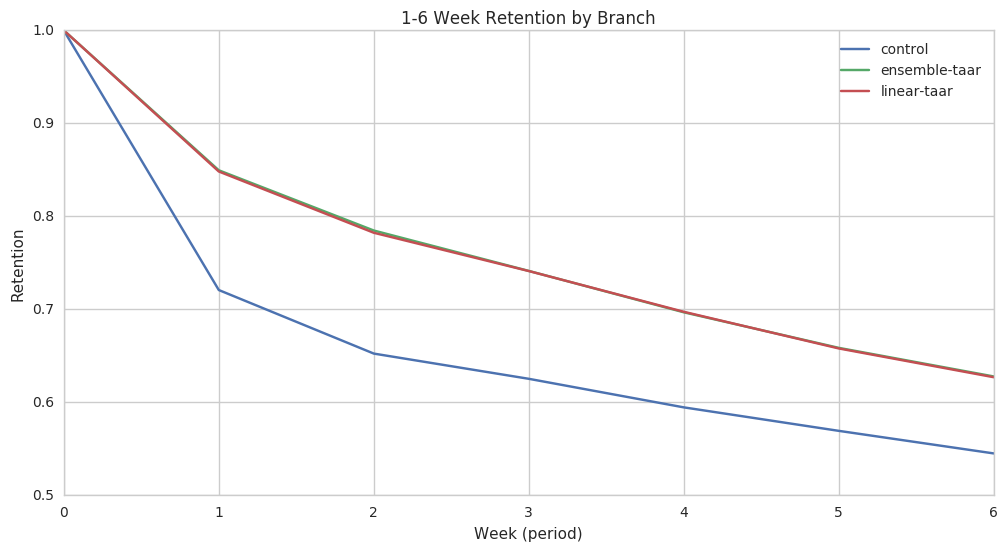

In [112]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()
for group, data in ret.groupby("branch"):
    (data.sort_values("period")
         .plot(x='period', 
               y='retention', 
               ax=ax, 
               label=group))
plt.ylabel("Retention")
plt.xlabel("Week (period)")
plt.title("1-6 Week Retention by Branch")
plt.show()

In [96]:
ret[ret.period == 6.0].sort_values("retention", ascending=False)

,branch,period,n_week_clients,total_clients,retention
1,ensemble-taar,6.0,77880,124049,0.627816
19,linear-taar,6.0,77576,123728,0.626988
13,control,6.0,620751,1138877,0.545055
